In [1]:
import re
from dataclasses import asdict
from glob import glob
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.data_io import (
    get_confounds_data,
    get_subids_bids_dir,
    load_tsv_data,
    resolve_file,
)


In [2]:
cfg = load_config()

In [3]:
good_subs_csv = cfg.subject_lists / 'initial_qa_pass_subjects_runs.csv'
good_subs = pd.read_csv(good_subs_csv)
good_subs

,sub_id,session,run
0,dmp0005,scan1,1
1,dmp0005,scan1,2
2,dmp0005,scan1,3
3,dmp0005,scan1,4
4,dmp0011,scan1,1
...,...,...,...
466,dmp1271,scan1,4
467,dmp1291,scan1,1
468,dmp1291,scan1,2
469,dmp1291,scan1,3


In [4]:
all_behav = []

for row in good_subs.itertuples(index=False):
    sub_id = row.sub_id
    session = row.session
    run = row.run
    behav_file = resolve_file(cfg, sub_id, session, run, 'behav')
    behav_data = load_tsv_data(behav_file)
    behav_data['sub_id'] = sub_id
    behav_data['run'] = run
    all_behav.append(behav_data)

In [5]:
all_behav_df = pd.concat(all_behav)
all_behav_df

,onset,duration,amount,Delay,choseAccept,RT,choseRight,sub_id,run
0,10.105,4,36,159,0.0,1.575,0.0,dmp0005,1
1,18.144,4,26,27,0.0,3.296,0.0,dmp0005,1
2,26.217,4,40,163,0.0,1.222,0.0,dmp0005,1
3,37.242,4,26,44,0.0,1.949,0.0,dmp0005,1
4,51.286,4,39,136,0.0,1.145,0.0,dmp0005,1
...,...,...,...,...,...,...,...,...,...
25,264.904,4,64,89,1.0,1.031,1.0,dmp1291,4
26,272.937,4,41,174,0.0,2.377,0.0,dmp1291,4
27,282.970,4,76,161,1.0,1.414,1.0,dmp1291,4
28,299.003,4,33,103,0.0,1.914,0.0,dmp1291,4


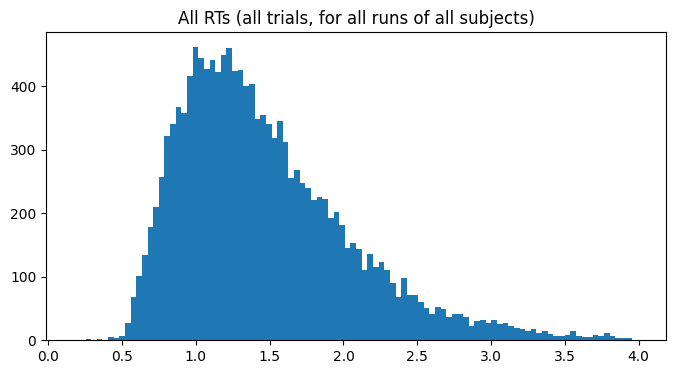

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(all_behav_df['RT'], 100)
plt.title('All RTs (all trials, for all runs of all subjects)')
plt.show()

In [7]:
mean_rt_run_df = all_behav_df.groupby(['sub_id', 'run'], as_index=False).agg(
    mean_rt=('RT', 'mean')
)

mean_rt_subject_df = all_behav_df.groupby('sub_id', as_index=False).agg(
    mean_rt=('RT', 'mean')
)

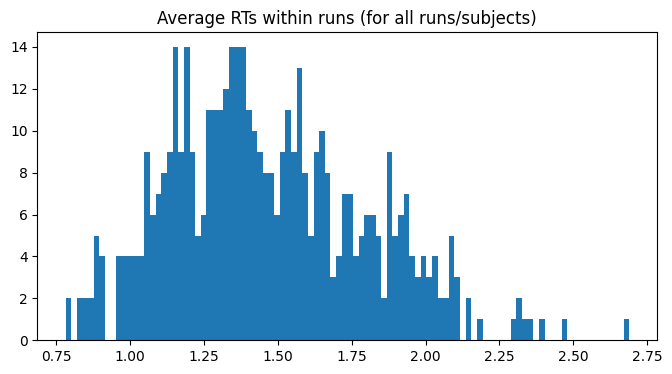

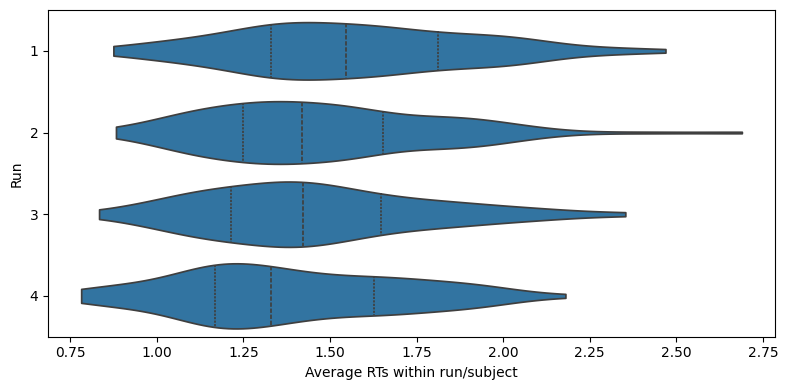

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(mean_rt_run_df['mean_rt'], 100)
plt.title('Average RTs within runs (for all runs/subjects)')
plt.show()


plt.figure(figsize=(8, 4))
sns.violinplot(
    data=mean_rt_run_df,
    x='mean_rt',
    y='run',
    orient='h',  # horizontal violins
    cut=0,  # don't extend beyond data range
    inner='quartile',  # show median + IQR
)

plt.xlabel('Average RTs within run/subject')
plt.ylabel('Run')
plt.tight_layout()
plt.show()

In [9]:
all_behav_df

,onset,duration,amount,Delay,choseAccept,RT,choseRight,sub_id,run
0,10.105,4,36,159,0.0,1.575,0.0,dmp0005,1
1,18.144,4,26,27,0.0,3.296,0.0,dmp0005,1
2,26.217,4,40,163,0.0,1.222,0.0,dmp0005,1
3,37.242,4,26,44,0.0,1.949,0.0,dmp0005,1
4,51.286,4,39,136,0.0,1.145,0.0,dmp0005,1
...,...,...,...,...,...,...,...,...,...
25,264.904,4,64,89,1.0,1.031,1.0,dmp1291,4
26,272.937,4,41,174,0.0,2.377,0.0,dmp1291,4
27,282.970,4,76,161,1.0,1.414,1.0,dmp1291,4
28,299.003,4,33,103,0.0,1.914,0.0,dmp1291,4


### I wondered what choseAccept and choseRight were
The code below explores this...but then Josh just told me

From the database uploader:
```
{
	"amount": {
		"Description": "Monetary dollar amount for the delayed option"
	},
	"Delay": {
		"Description": "Delay (in days) until the receipt of the delayed option"
	},
	"choseAccept": {
		"Description": "1 if participant chose the delayed option. 0 if participant chose the immediate option of $20 now"
	},
	"RT": {
		"Description": "Response Time"
	},
	"choseRight": {
		"Description": "1 if participant pressed the right button. 0 if left."
	}
}
```

In [10]:
# I wanted to check that if RT was missing choseAccept and choseRight were also missing

cols = ['RT', 'choseAccept', 'choseRight']
missing_matrix = pd.DataFrame(0, index=cols, columns=cols, dtype=int)

for col_missing in cols:
    for col_present in cols:
        if col_missing == col_present:
            continue
        missing_matrix.loc[col_missing, col_present] = (
            all_behav_df[col_missing].isna() & all_behav_df[col_present].notna()
        ).sum()

# If all 0s it means there is no trial where one of the three measures was missing and one of the others was not.
missing_matrix

,RT,choseAccept,choseRight
RT,0,0,0
choseAccept,0,0,0
choseRight,0,0,0


In [11]:
# Count missing in each column
missing_per_col = all_behav_df[cols].isna().sum()

# Count rows where all three are missing
missing_all_three = all_behav_df[cols].isna().all(axis=1).sum()

print('Missing per column:\n', missing_per_col)
print('\nNumber of rows missing in all three columns:', missing_all_three)

Missing per column:
 RT             48
choseAccept    48
choseRight     48
dtype: int64

Number of rows missing in all three columns: 48


In [12]:
# I was trying to figure out the difference between choseRight and choseAccept.

valid_rows = all_behav_df[['choseRight', 'choseAccept']].dropna()

# Count total matches and mismatches
num_matches = (valid_rows['choseRight'] == valid_rows['choseAccept']).sum()
num_mismatches = (valid_rows['choseRight'] != valid_rows['choseAccept']).sum()
total_checked = len(valid_rows)

print(f'Checked {total_checked} rows (excluding missing)')
print(f'Matches: {num_matches} ({num_matches / total_checked:.1%})')
print(f'Mismatches: {num_mismatches} ({num_mismatches / total_checked:.1%})')

Checked 14112 rows (excluding missing)
Matches: 7104 (50.3%)
Mismatches: 7008 (49.7%)
